In [1]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from scipy.stats import ranksums

In [5]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 500

In [6]:
from scipy.stats import false_discovery_control

In [7]:
import random
import seaborn as sns

# Chromosome-wide fold-changes

In [8]:
df = pd.read_csv("../../counts_df.csv", index_col=0)

In [9]:
adata = sc.AnnData(df.T)

In [10]:
adata.obs.index = ["-".join(i.split(".")) for i in adata.obs.index]

In [11]:
print(adata.shape)
sc.pp.filter_genes(adata, min_cells = 10)
print(adata.shape)

(20800, 21630)
(20800, 18099)


In [12]:
sc.pp.normalize_total(adata)

In [13]:
rearr = pd.read_csv("../../20240914_Lane2__1UMI_rearrangements.tsv", sep="\t", index_col=0)

In [14]:
rearr['key'] = rearr['rearranged_real_barcode1']+","+rearr['rearranged_real_barcode2']

In [15]:
del_cells = []
with open("deletion_cells.txt", "r+") as f:
    del_cells = f.read().splitlines()

In [16]:
parent_cells = []
with open("parental_cells.txt", "r+") as f:
    parent_cells = f.read().splitlines()

In [17]:
len(del_cells)

465

In [18]:
len(parent_cells)

680

In [19]:
all_cells = del_cells+parent_cells

In [20]:
len(del_cells)+len(parent_cells)

1145

In [21]:
len(set(all_cells))

1145

In [22]:
adata_test = adata[all_cells,:].copy()

In [23]:
adata_test.obs['chr15_del'] = "No"

In [24]:
adata_test.obs.loc[del_cells, 'chr15_del'] = "Yes"

In [27]:
gff3 = "../../gencode.v38.basic.annotation.gff3"

In [28]:
gencode = pd.read_table(gff3, comment="#", sep = "\t", names = ['seqname', 'source', 'feature', 'start' , 'end', 'score', 'strand', 'frame', 'attribute'])
gencode.head() 
gencode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1873108 entries, 0 to 1873107
Data columns (total 9 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   seqname    object
 1   source     object
 2   feature    object
 3   start      int64 
 4   end        int64 
 5   score      object
 6   strand     object
 7   frame      object
 8   attribute  object
dtypes: int64(2), object(7)
memory usage: 128.6+ MB


In [29]:
gencode_genes = gencode[(gencode.feature == "gene")][['seqname', 'start', 'end', 'attribute']].copy().reset_index().drop('index', axis=1)

In [30]:
gencode_genes['gene_name'] = [i.split("gene_name=")[1].split(";")[0] for i in gencode_genes['attribute'].values]

In [31]:
chr15 = gencode_genes[gencode_genes['seqname']=="chr15"]

In [32]:
start = 50426416
end = 50873610

In [33]:
start_left = 0 #start-10000000
end_right = max(chr15['end'])+1000 #end+10000000

In [34]:
del_idx = []
for i in chr15.index:
    if chr15.loc[i,"start"] >= start_left and chr15.loc[i,"end"] <= end_right:
        del_idx.append(i)
        #print(1)
    elif chr15.loc[i,"end"] >= start_left and chr15.loc[i,"end"] <= end_right:
        del_idx.append(i)
        #print(2)
    elif chr15.loc[i,"start"] >= start_left and chr15.loc[i,"start"] <= end_right:
        del_idx.append(i)
        #print(3)

In [35]:
del_genes = chr15.loc[del_idx, "gene_name"].values

In [36]:
gen = [i for i in del_genes if i in adata.var.index]

In [37]:
gen_df = chr15[chr15['gene_name'].isin(gen)]

In [38]:
gen_df.set_index("gene_name", inplace=True)

In [39]:
gen_df

,seqname,start,end,attribute
gene_name,,,,
LINC01193,chr15,20940380,21058440,ID=ENSG00000258710.8;gene_id=ENSG00000258710.8...
AC138649.1,chr15,22714939,22715225,ID=ENSG00000277867.1;gene_id=ENSG00000277867.1...
NIPA1,chr15,22773063,22829789,ID=ENSG00000170113.16;gene_id=ENSG00000170113....
NIPA2,chr15,22838644,22869362,ID=ENSG00000140157.16;gene_id=ENSG00000140157....
CYFIP1,chr15,22867052,22981063,ID=ENSG00000273749.5;gene_id=ENSG00000273749.5...
...,...,...,...,...
SNRPA1,chr15,101281510,101295282,ID=ENSG00000131876.17;gene_id=ENSG00000131876....
PCSK6,chr15,101289784,101525202,ID=ENSG00000140479.18;gene_id=ENSG00000140479....
PCSK6-AS1,chr15,101334437,101337428,ID=ENSG00000259764.1;gene_id=ENSG00000259764.1...


In [40]:
info_df = pd.DataFrame(index=gen, columns=['Fold-change', 'p-value', 'start', 'end', '%_group', '%_rest'])

In [41]:
group = adata_test.obs[adata_test.obs['chr15_del']=="Yes"].index
rest = adata_test.obs[adata_test.obs['chr15_del']=="No"].index
for i in info_df.index:
    info_df.loc[i,"Fold-change"] = np.mean(adata_test[group,i].X)/np.mean(adata_test[rest,i].X)
    info_df.loc[i,"start"] = gen_df.loc[i,"start"]
    info_df.loc[i,"end"] = gen_df.loc[i,"end"]
    info_df.loc[i,"p-value"] = ranksums(adata_test[group,i].X, adata_test[rest,i].X, alternative='less')[1]
    info_df.loc[i,"%_group"] = np.count_nonzero(adata_test[group,i].X)/len(group)
    info_df.loc[i,"%_rest"] = np.count_nonzero(adata_test[rest,i].X)/len(rest)

In [42]:
info_df

,Fold-change,p-value,start,end,%_group,%_rest
LINC01193,NaN,0.5,20940380,21058440,0.0,0.0
AC138649.1,1.031053,0.5675534576016079,22714939,22715225,0.062366,0.055882
NIPA1,0.96264,0.5502497220332335,22773063,22829789,0.150538,0.144118
NIPA2,0.828058,0.1529207892110272,22838644,22869362,0.301075,0.327941
CYFIP1,0.861841,0.3170183822480743,22867052,22981063,0.217204,0.229412
...,...,...,...,...,...,...
SNRPA1,0.910839,0.02106507390693063,101281510,101295282,0.741935,0.788235
PCSK6,1.172984,0.6402179215367612,101289784,101525202,0.068817,0.055882
PCSK6-AS1,4.839606,0.5078401296553244,101334437,101337428,0.002151,0.001471
TM2D3,1.391897,0.9044334470459958,101621444,101652391,0.191398,0.15


In [43]:
info_df = info_df[info_df["%_group"]>=0.1]
info_df = info_df[info_df["%_rest"]>=0.1]

In [44]:
info_df['p-bh'] = false_discovery_control(info_df['p-value'].values.astype(float))
info_df['p-bonferroni'] = info_df['p-value']*info_df.shape[0]

In [45]:
info_df[info_df['p-value']<=0.05]

,Fold-change,p-value,start,end,%_group,%_rest,p-bh,p-bonferroni
EID1,0.847768,0.0001815306426335597,48878134,48880173,0.804301,0.829412,0.041752,0.041752
USP8,0.696859,0.013165095902601539,50424380,50514421,0.234409,0.304412,0.605594,3.027972
TRPM7,0.632311,0.00046257519692091394,50552473,50686797,0.215054,0.329412,0.053196,0.106392
SPPL2A,0.605961,0.005182266390815851,50702266,50765709,0.15914,0.245588,0.297980,1.191921
ARPP19,0.82684,0.04083578811215718,52547045,52569883,0.391398,0.438235,0.998202,9.392231
RCCD1,0.655439,0.0020081400533134524,90954870,90963125,0.187097,0.285294,0.153957,0.461872
SNRPA1,0.910839,0.02106507390693063,101281510,101295282,0.741935,0.788235,0.807494,4.844967


In [46]:
start,end

(50426416, 50873610)

In [47]:
info_df.to_csv("gene_pvalues_chr15.csv", index=True)

In [48]:
info_df['center'] = (info_df['start']+info_df['end'])/2

In [49]:
moving_avg = np.convolve(info_df['Fold-change'], np.ones(3)/3, mode='valid')

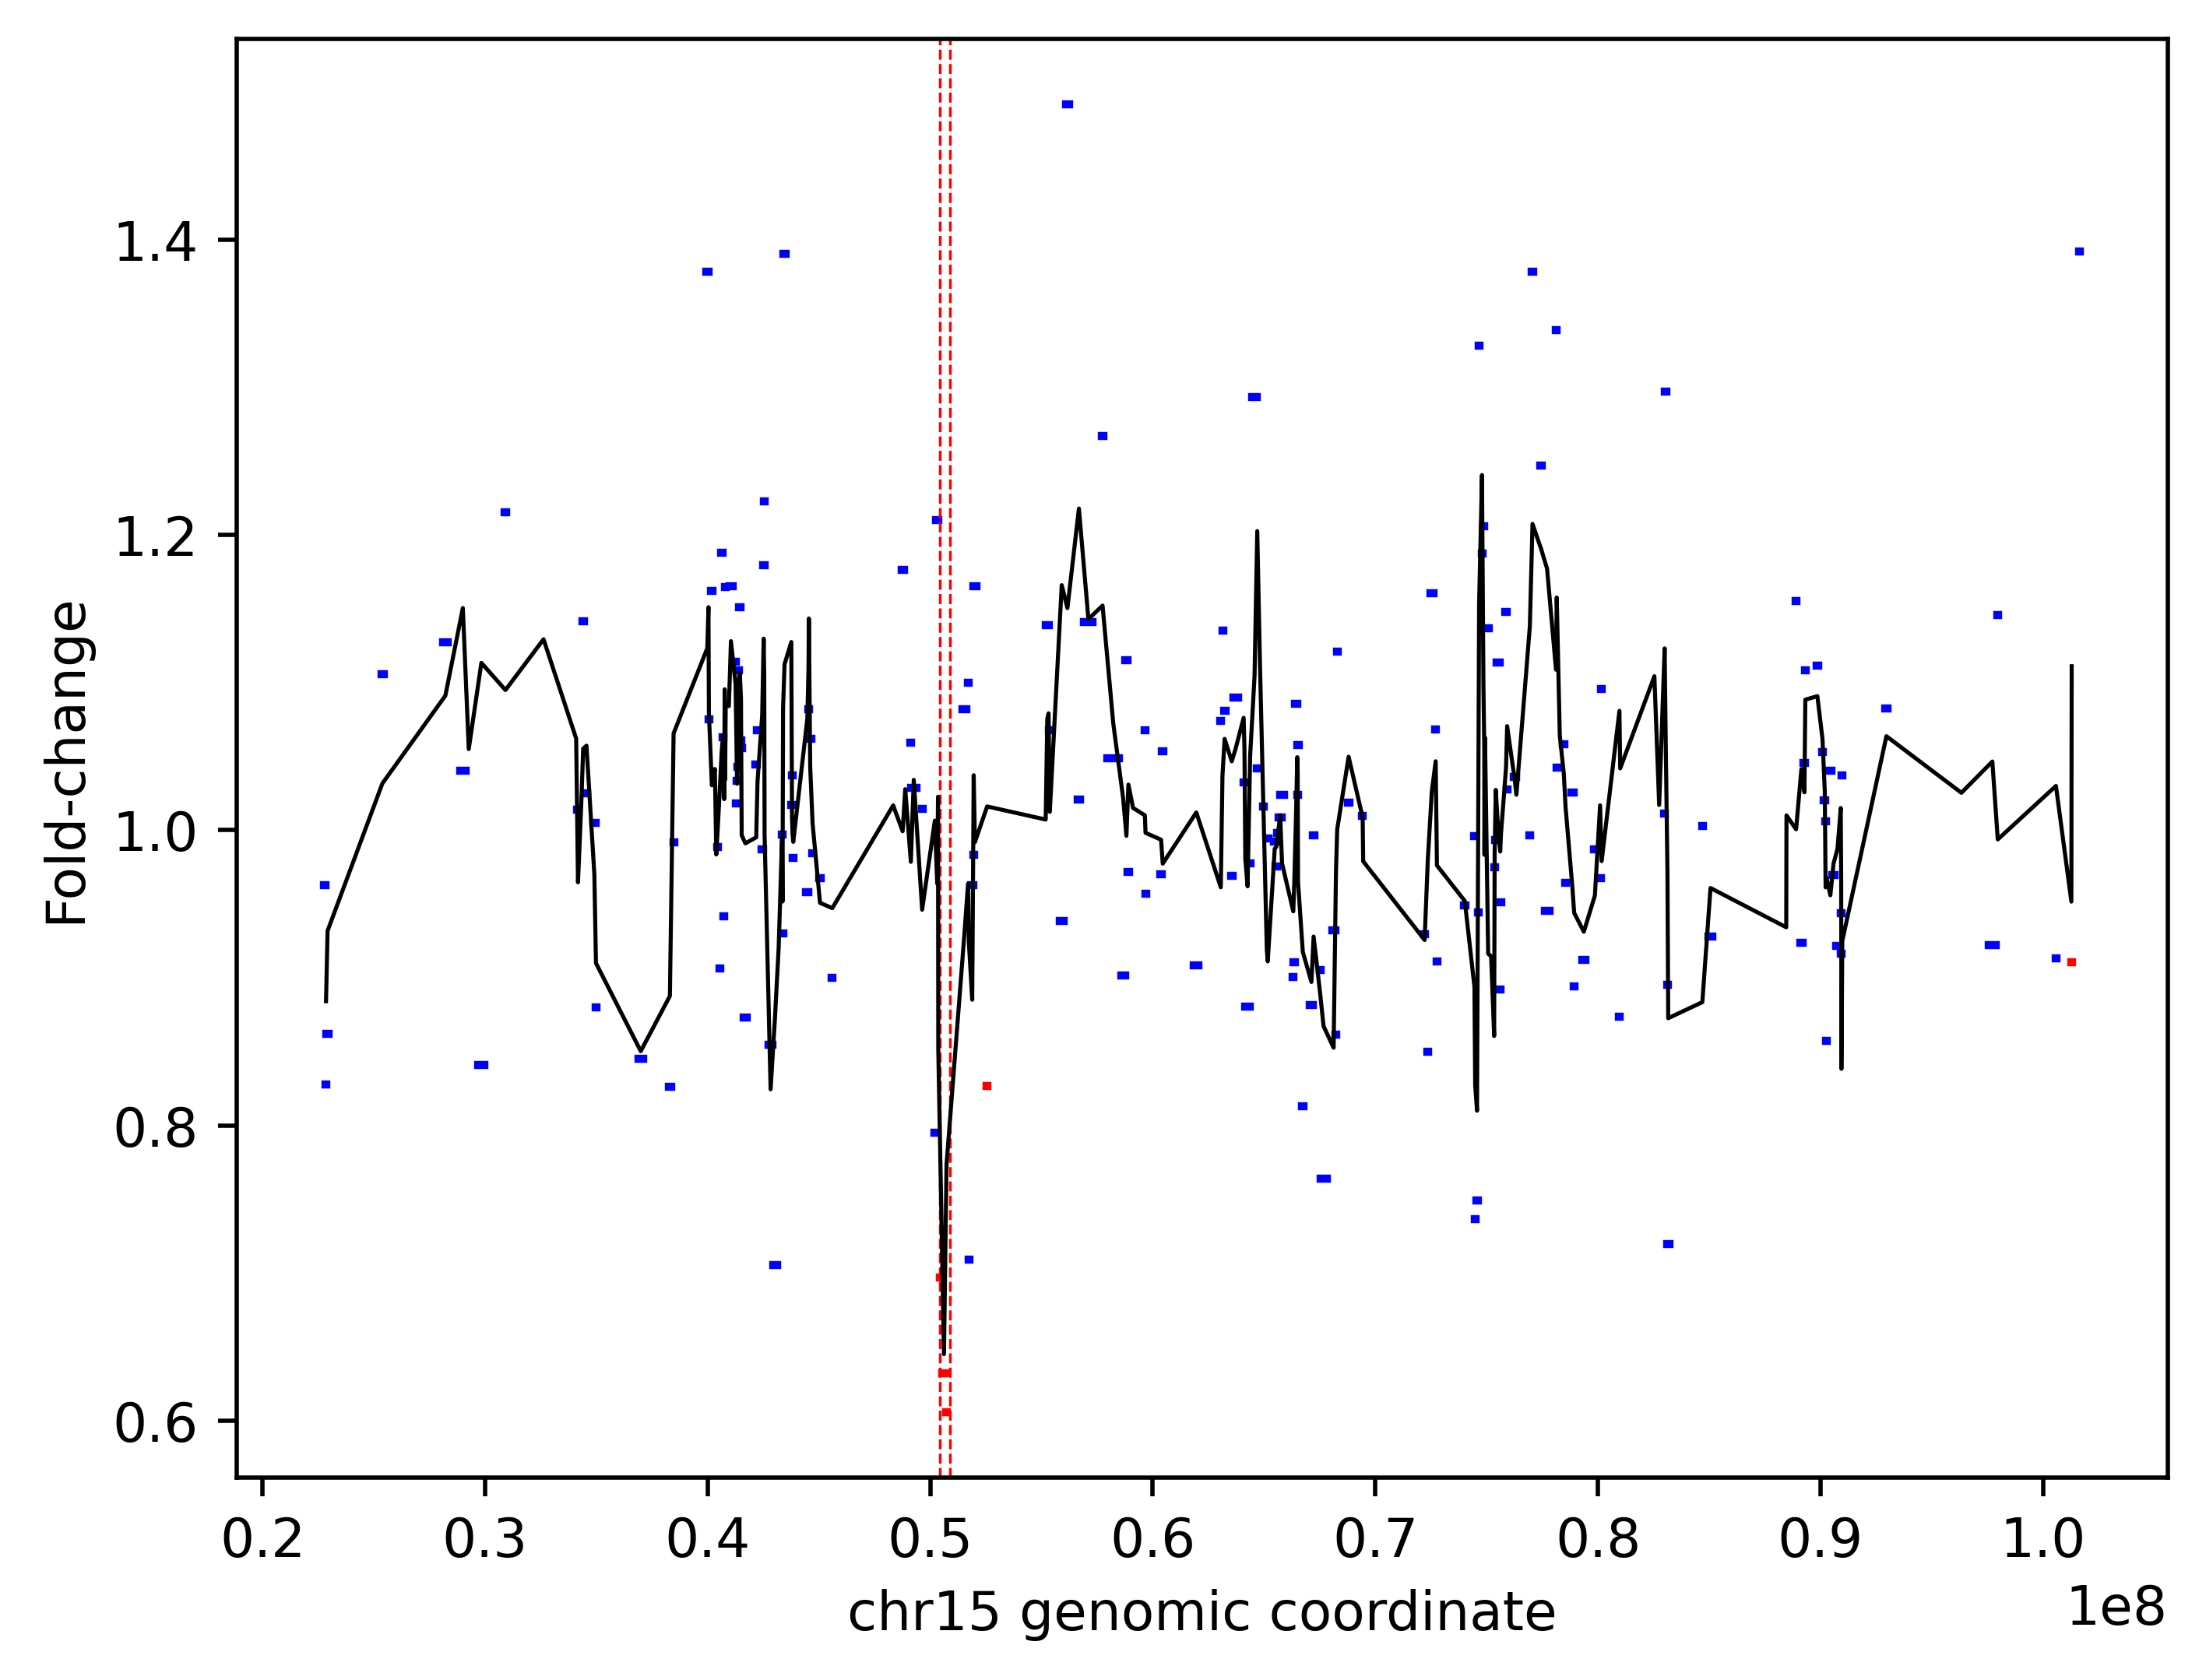

In [50]:
for i in info_df.index:
    plt.plot([info_df.loc[i,"start"],info_df.loc[i,"end"]],
              [info_df.loc[i,"Fold-change"],info_df.loc[i,"Fold-change"]], 
             color="blue" if float(info_df.loc[i,"p-value"]) > 0.05 else "red")#, 
             #alpha=1-float(info_df.loc[i,"p-value"]))#, cmap="Reds")
plt.axvline(x=start, linestyle="--", linewidth=0.5, color="red")
plt.axvline(x=end, linestyle="--", linewidth=0.5, color="red")
plt.xlabel("chr15 genomic coordinate")
plt.ylabel("Fold-change")

plt.plot(info_df.iloc[1:-1,:]['center'], moving_avg, color="black", linewidth=0.75)
plt.savefig("chr15_total.pdf", dpi=500)
plt.show()

# Downsampling cell number

In [51]:
start = 50426416
end = 50873610

In [52]:
start_left = start#-10000000
end_right = end#+10000000

In [53]:
del_idx = []
for i in chr15.index:
    if chr15.loc[i,"start"] >= start_left and chr15.loc[i,"end"] <= end_right:
        del_idx.append(i)
        #print(1)
    elif chr15.loc[i,"end"] >= start_left and chr15.loc[i,"end"] <= end_right:
        del_idx.append(i)
        #print(2)
    elif chr15.loc[i,"start"] >= start_left and chr15.loc[i,"start"] <= end_right:
        del_idx.append(i)
        #print(3)

In [54]:
del_genes = chr15.loc[del_idx, "gene_name"].values

In [55]:
gen = [i for i in del_genes if i in adata.var.index]

In [56]:
gen_df = chr15[chr15['gene_name'].isin(gen)]

In [57]:
gen_df.set_index("gene_name", inplace=True)

In [58]:
gen_df

,seqname,start,end,attribute
gene_name,,,,
USP8,chr15,50424380,50514421,ID=ENSG00000138592.14;gene_id=ENSG00000138592....
TRPM7,chr15,50552473,50686797,ID=ENSG00000092439.16;gene_id=ENSG00000092439....
SPPL2A,chr15,50702266,50765709,ID=ENSG00000138600.10;gene_id=ENSG00000138600....


In [59]:
info_df = pd.DataFrame(index=gen, columns=['Fold-change', 'p-value', 'start', 'end', '%_group', '%_rest'])

In [60]:
from scipy.stats import ranksums

In [61]:
group = adata_test.obs[adata_test.obs['chr15_del']=="Yes"].index
rest = adata_test.obs[adata_test.obs['chr15_del']=="No"].index
for i in info_df.index:
    info_df.loc[i,"Fold-change"] = np.mean(adata_test[group,i].X)/np.mean(adata_test[rest,i].X)
    info_df.loc[i,"start"] = gen_df.loc[i,"start"]
    info_df.loc[i,"end"] = gen_df.loc[i,"end"]
    info_df.loc[i,"p-value"] = ranksums(adata_test[group,i].X, adata_test[rest,i].X, alternative='less')[1]
    info_df.loc[i,"%_group"] = np.count_nonzero(adata_test[group,i].X)/len(group)
    info_df.loc[i,"%_rest"] = np.count_nonzero(adata_test[rest,i].X)/len(rest)

In [62]:
info_df = info_df[info_df["%_group"]>=0.1]
info_df = info_df[info_df["%_rest"]>=0.1]

In [63]:
info_df

,Fold-change,p-value,start,end,%_group,%_rest
USP8,0.696859,0.013165095902601539,50424380,50514421,0.234409,0.304412
TRPM7,0.632311,0.00046257519692091394,50552473,50686797,0.215054,0.329412
SPPL2A,0.605961,0.005182266390815851,50702266,50765709,0.15914,0.245588


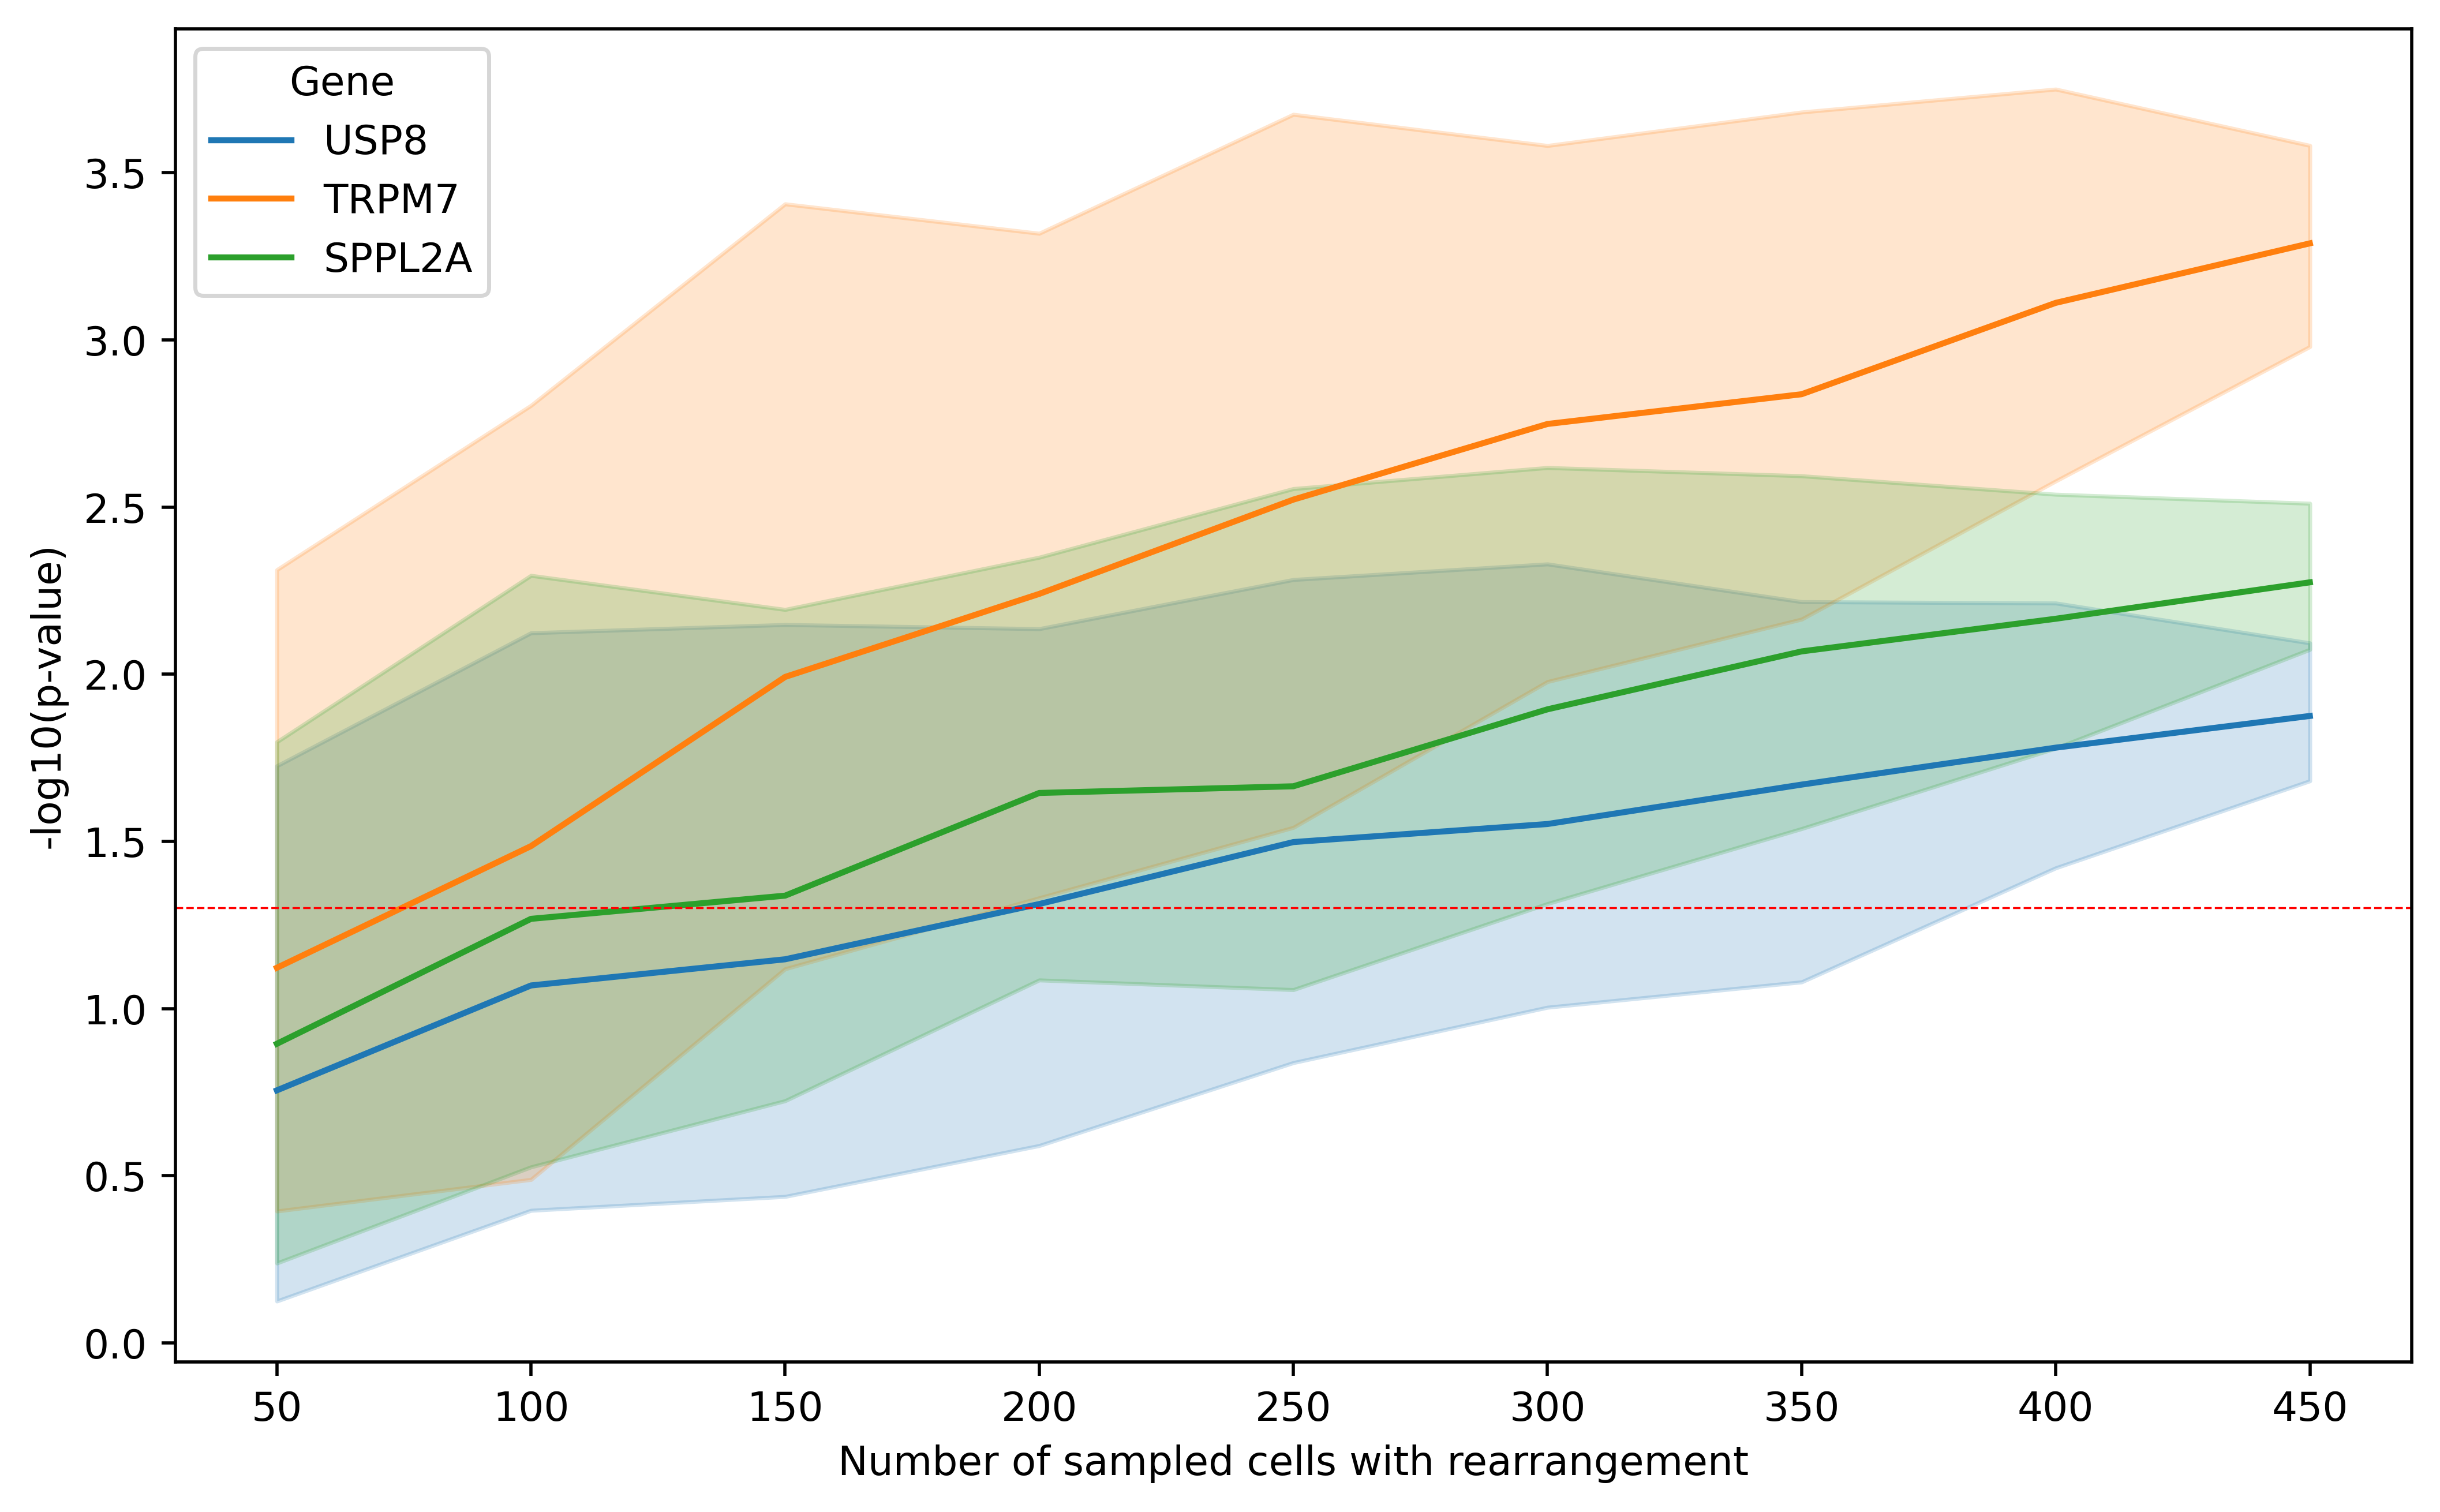

In [64]:
cell_counts = [50, 100, 150, 200, 250, 300, 350, 400, 450]
genes = ['USP8', 'TRPM7', 'SPPL2A']
n_iterations = 100

results = []

for cell_count in cell_counts:
    for iteration in range(n_iterations):
        rest = adata_test.obs[adata_test.obs['chr15_del'] == "No"].index
        group = random.sample(del_cells, cell_count)
        for gene in genes:
            p_value = ranksums(adata_test[group, gene].X, adata_test[rest, gene].X, alternative='less')[1]
            results.append({
                'cell_count': cell_count,
                'gene': gene,
                'p_value': float(p_value),
                'neg_log10_p': float(-np.log10(p_value))
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='cell_count', y='neg_log10_p', hue='gene', errorbar=('pi', 95))

plt.xlabel("Number of sampled cells with rearrangement")
plt.ylabel("-log10(p-value)")
plt.axhline(y=-np.log10(0.05), linestyle="--", linewidth=0.5, color="red")
#plt.title("P-value evolution with confidence intervals")
plt.legend(title="Gene")
plt.savefig("downsampling_pvalue.pdf", dpi=500)
plt.show()

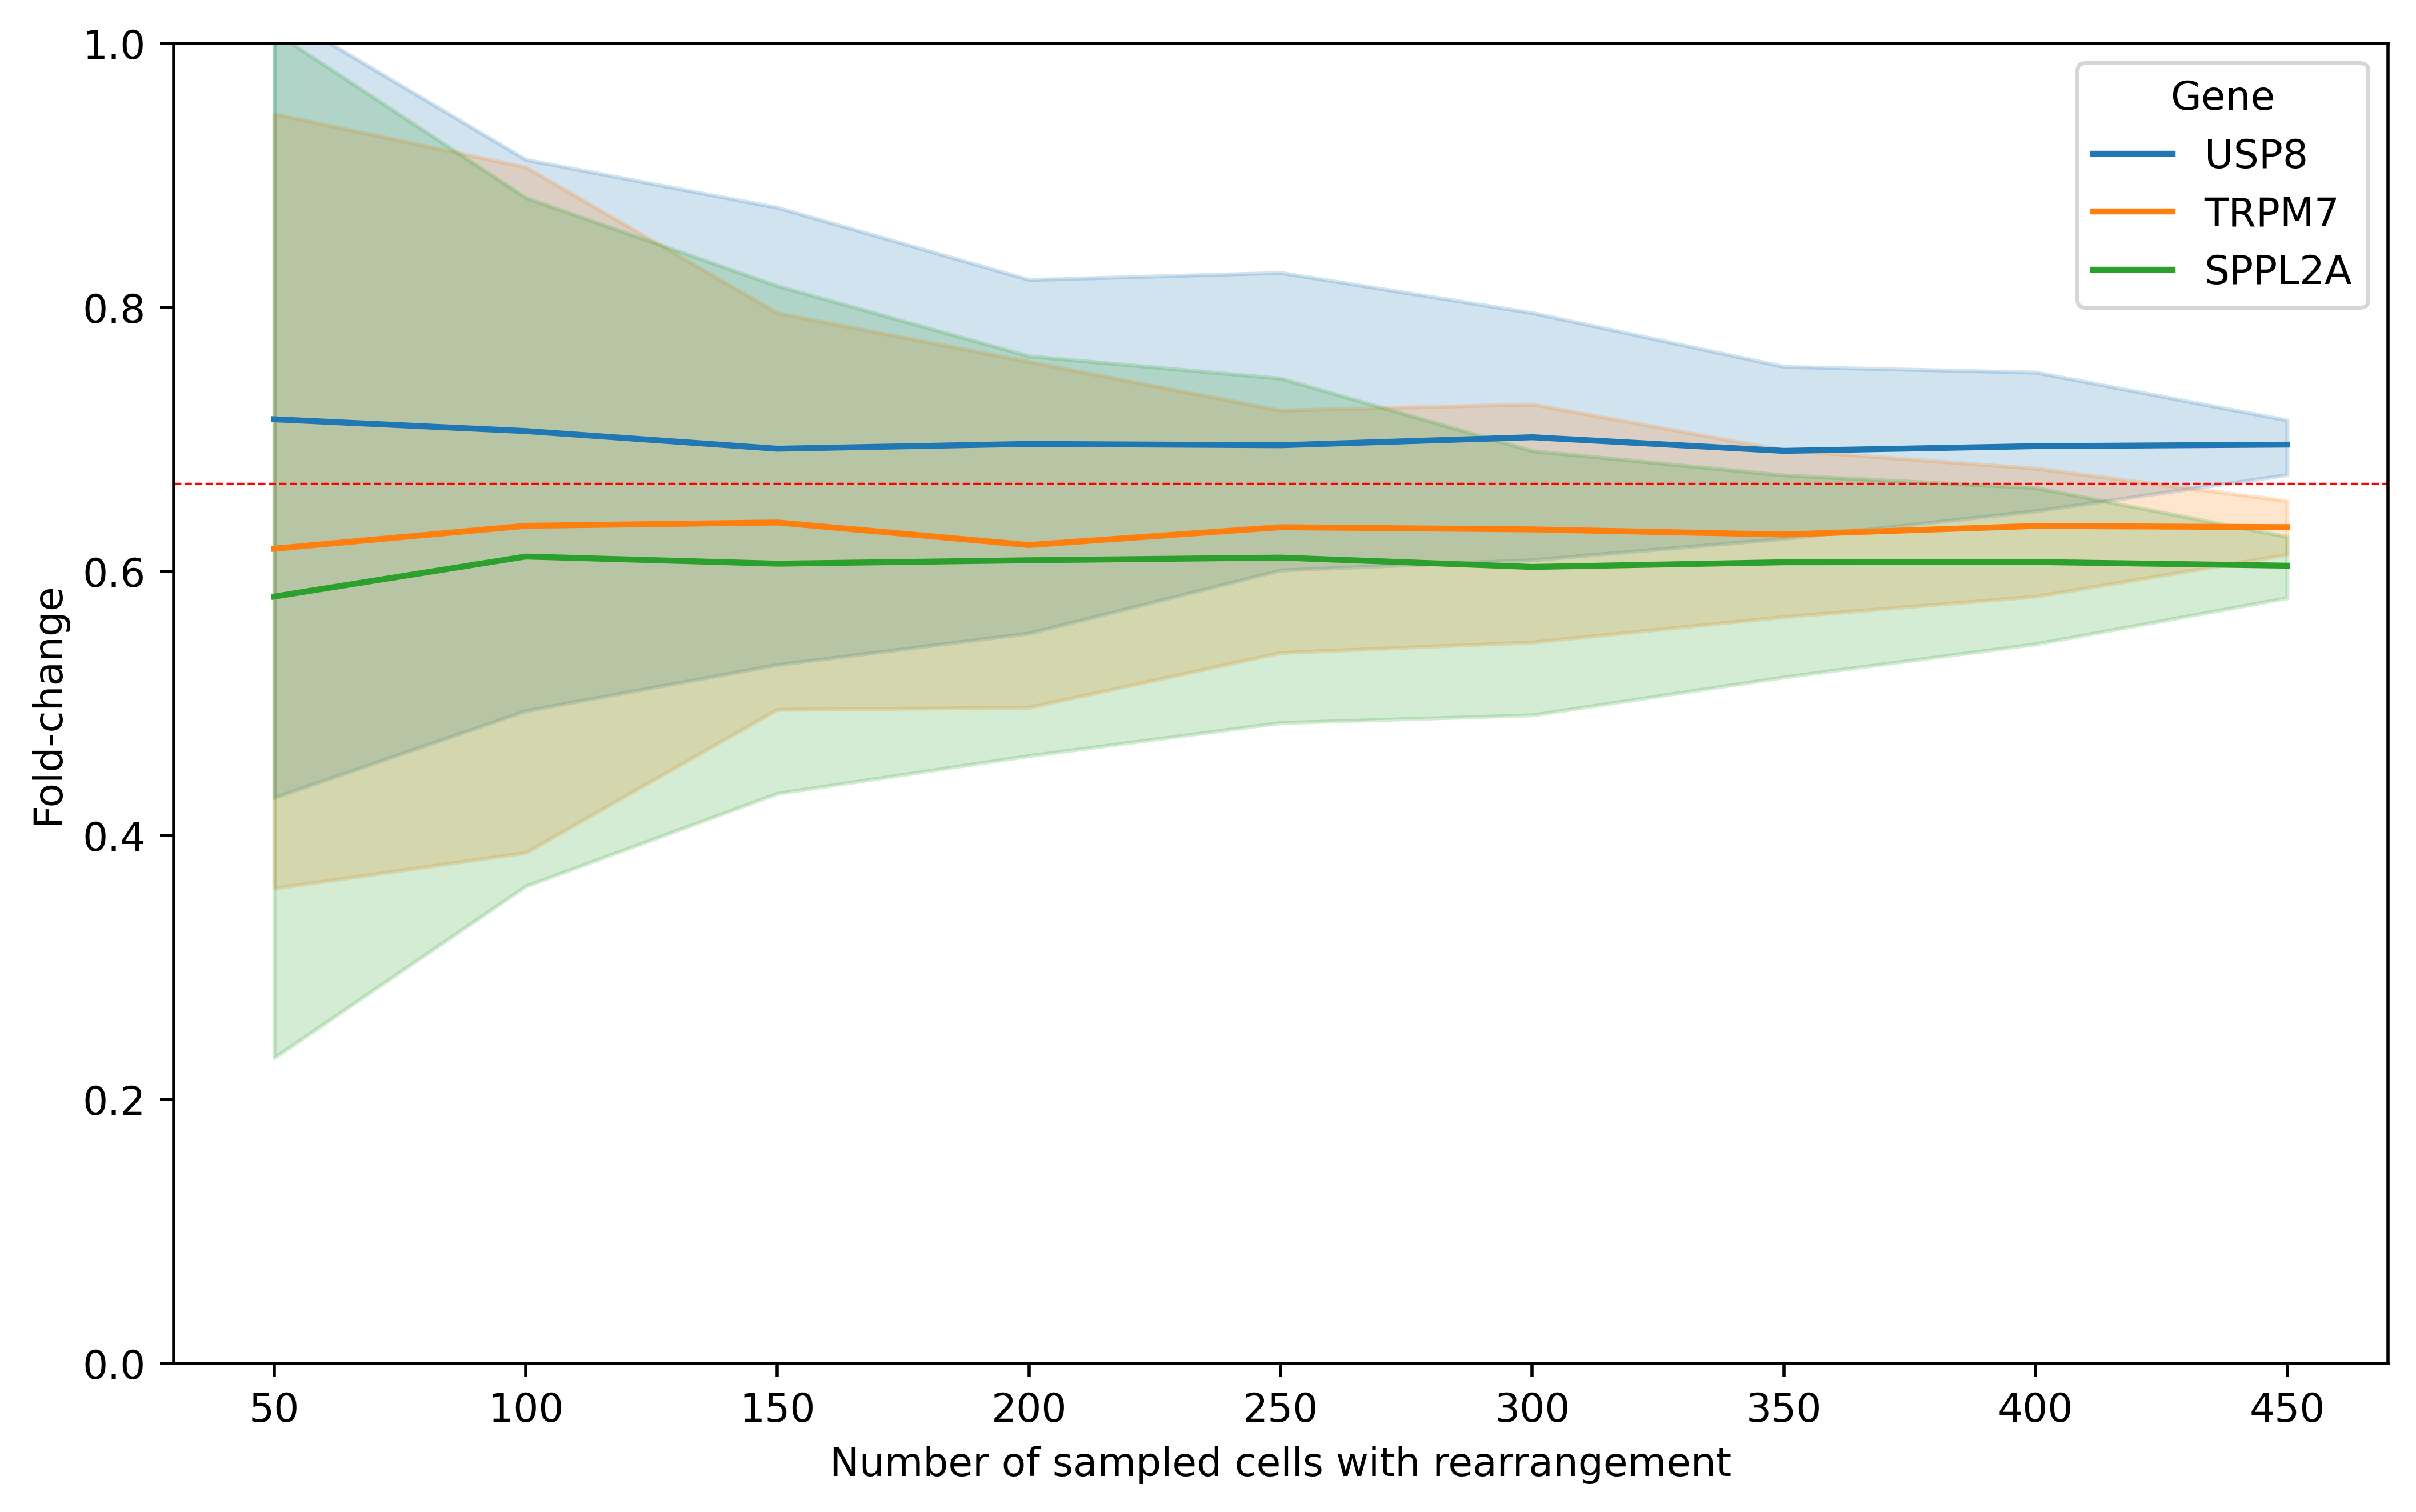

In [65]:
cell_counts = [50, 100, 150, 200, 250, 300, 350, 400, 450]
genes = ['USP8', 'TRPM7', 'SPPL2A']
n_iterations = 100

results = []

for cell_count in cell_counts:
    for iteration in range(n_iterations):
        rest = adata_test.obs[adata_test.obs['chr15_del'] == "No"].index
        group = random.sample(del_cells, cell_count)
        for gene in genes:
            p_value = np.mean(adata_test[group,gene].X)/np.mean(adata_test[rest,gene].X)
            results.append({
                'cell_count': cell_count,
                'gene': gene,
                'Fold-change': float(p_value),
                'neg_log10_p': float(-np.log10(p_value))
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='cell_count', y='Fold-change', hue='gene', errorbar=('pi',95))

plt.xlabel("Number of sampled cells with rearrangement")
plt.ylabel("Fold-change")
plt.ylim([0,1])
plt.axhline(y=(2.0/3.0), linestyle="--", linewidth=0.5, color="red")
#plt.title("Fold- evolution with confidence intervals")
plt.legend(title="Gene")
plt.savefig("downsampling_foldchange.pdf", dpi=500)
plt.show()